In [2]:
# 코드: https://github.com/rickiepark/handson-gb/blob/main/Appendix/other_gradient_boosting.ipynb 
# 설명: https://mac-user-guide.tistory.com/79

LightGBM의 leaf wise tree분할 방식은 tree의 균형을 고려하지 않고 최대 손실 값(max data loss)를 가지는 leaf node를 지속적으로 분할하면서 tree의 깊이가 깊어지고 비대칭적인 tree가 생성된다. 이와같이 최대 손실값을 가지는 leaf node를 반복 분할하는 방식은 level wise tree분할 방식보다 예측 오류 손실을 최소화할 수 있다.
출처: https://mac-user-guide.tistory.com/79 [🌷나의 선인장🌵:티스토리]

## 일반적인 GBM에 대한 설명
- 일반적 GBM 알고리즘은 기본적으로 트리 모델을 기반으로 하고 있다. 
- 정답과 오답 간의 차이를 반복적으로 학습시킨다.
- tree1을 가지고 평범하게 타겟y를 예측
- tree2는 residual을 예측
- tree3는 tree2의 residual을 예측
- 여기서 tree는 최대한 균형이 잡힌 트리를 유지하면서 분할시키는 것이다. 
- tree의 깊이는 최소화한다. 
- 이 균형을 맞추기 위해서 시간이 필요하다. 

## Light GBM에 대한 설명
- tree의 균형은 무시하고, 최대 손실 값을 가진 leaf를 집중적으로 분할하여 비대칭적인 tree를 허용하는 방식을 사용한다.
- 즉 균형을 무시하면서 가장 높은 이익을 얻는 것을 우선적으로 노드를 분할하는 것이다. 
- 균형을 맞출 필요가 없기 때문에 속도가 빠르다고 한다. 

In [1]:
import pandas as pd

df = pd.read_csv('../data/student-por.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,NaN,18.0,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,NaN,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15.0,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16.0,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [9]:
from sklearn.model_selection import train_test_split
y = df.iloc[:, -1]
X = df.iloc[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cat_columns = X_train.columns[X_train.dtypes==object].tolist()
for c in cat_columns:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

c:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [10]:
import lightgbm as lgb

lgbr = lgb.LGBMRegressor(random_state=42)

from scipy.stats import randint
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': randint(10, 100),
    'max_depth': randint(1, 10),
    'min_child_samples': randint(10, 40),
    'n_estimators': randint(50, 300),
    'learning_rate': loguniform(1e-3, 0.1),
    'subsample': loguniform(0.6, 1.0),
    'subsample_freq': randint(1, 5),
}

rs = RandomizedSearchCV(lgbr, param_grid, n_iter=300, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

print('최상의 매개변수:', rs.best_params_)
print('최상의 교차 검증 점수:', -rs.best_score_)

최상의 매개변수: {'learning_rate': 0.021887293880411753, 'max_depth': 3, 'min_child_samples': 17, 'n_estimators': 193, 'num_leaves': 45, 'subsample': 0.8656809331397646, 'subsample_freq': 2}
최상의 교차 검증 점수: 2.63508853549706


In [13]:
from sklearn.metrics import mean_squared_error
lgbr = rs.best_estimator_
y_pred = lgbr.predict(X_test)
mean_squared_error(y_pred, y_test, squared=False)

2.742443918665029

## 피쳐의 중요도

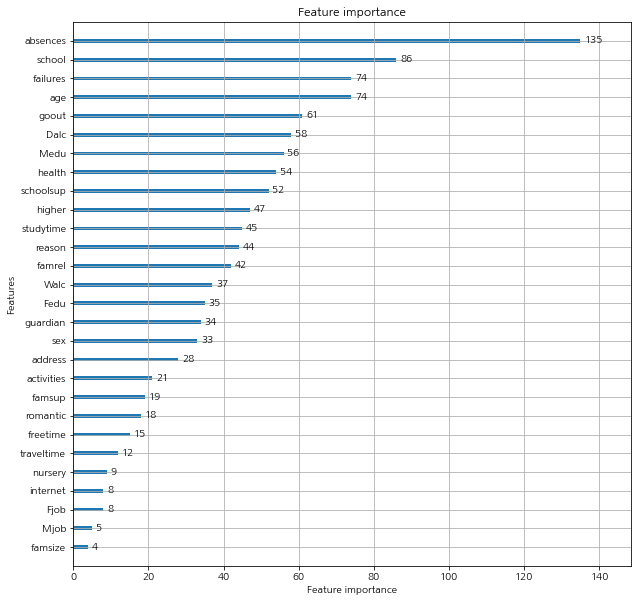

In [14]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgbr, figsize=(10,10))
plt.show()

## 8개의 tree모델로 만든 lgb모델을 트리그래프로

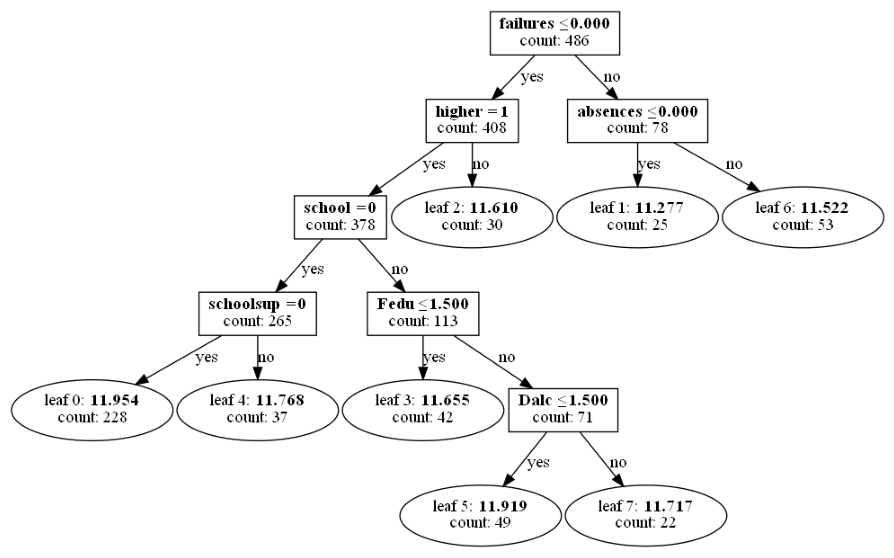

In [20]:
lgbr_8_trees = lgb.LGBMRegressor(num_leaves=8)
lgbr_8_trees.fit(X_train, y_train)
lgb.plot_tree(lgbr_8_trees, tree_index=0, figsize=(20,10),
              orientation='vertical', 
              show_info=['internal_count', 'leaf_count'])
plt.show()

## 리프별 트리 성장 과정
- num_leaves : 3 -> 4 -> 5 -> 6 -> 7 차례로 높였을 때의 변화
- num_leaves를 다르게 했을 때 첫 번째 트리의 그래프를 그린 것. 

3
4
5
6
7
8


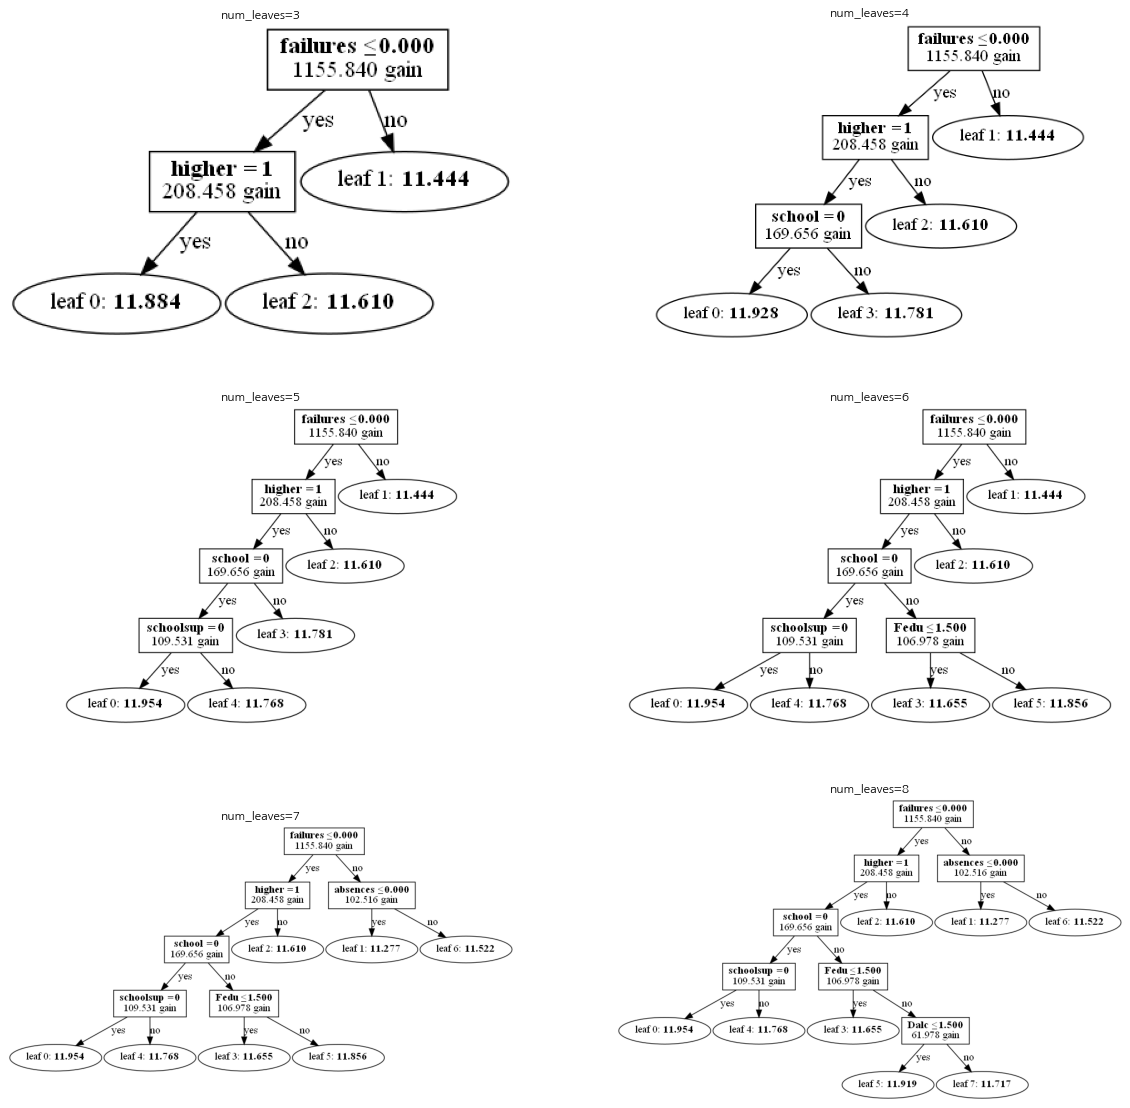

In [18]:
# 


fig, axs = plt.subplots(3, 2, figsize=(20,20))
for i in range(0, 3):
    for j in range(0, 2):
        lgbr2 = lgb.LGBMRegressor(num_leaves=i*2+j+3)
        print(i*2+j+3)
        lgbr2.fit(X_train, y_train)
        lgb.plot_tree(lgbr2, tree_index=0, show_info=['split_gain'],
                      orientation='vertical', ax=axs[i, j])
        axs[i, j].set_title('num_leaves={}'.format(i*2+j+3))